### Algorithm for the grouping of the data from the Medibio's ECG file set. 

##### Trying to apply Linear and Polynomial Support Vector Machines to the Hjorg parameters distribution

### written by Nicola Pastorello 17/11/2015

In [40]:
# library('party')
# library('RWeka')
library('caret')
# library('e1071')


In [41]:
originalDF = read.csv('metrics.csv')
# Check if missing data
is.na.data.frame <- function(obj){
                        sapply(obj,FUN = function(x) all(is.na(x)))
                        }
                            
isnt.finite.data.frame <- function(obj){
                        sapply(obj,FUN = function(x) all(!is.finite(x)))
                        }

           
# isnt.finite.data.frame(DF)
# is.na.data.frame(DF)
                               

# List of bad fitted profiles (the sleeping region is bad constrained)
badFit_DF = read.csv('BadFit.csv')
        
# Remove useless columns for the learning algorithms
DF <- originalDF                         
DF$X <- NULL  
DF$ID <- NULL    
                            
# Extracting only DF rows with well fitted sleeping regions
DF_badfit <- DF[badFit_DF$BadFit == 'True', ]
DF_notfit <- DF[badFit_DF$BadFit == 'nan', ]
DF <- DF[badFit_DF$BadFit == 'False', ]
     
# Removing potential empty levels in both test and training datasets
DF$label <- factor(DF$label)                            

In [42]:
DF$Log_H_complexity <- log(DF$H_complexity, base = exp(10))
DF$Log_H_mobility <- log(DF$H_mobility, base = exp(10))
nDF <- DF[,c("label","Log_H_complexity","Log_H_mobility")]

# Excluding from new data frame the moderate datapoints
nDF_sel <- nDF[((nDF$label == 'severe')|(nDF$label == 'mild')),]
nDF_sel <- na.omit(nDF_sel)
nDF_sel$label <- factor(nDF_sel$label)  # Removing moderate and nan from sample

train <- createFolds(nDF_sel$label, k=10)

In [6]:
# Linear Support Vector Machines
svmFit_linear <- train(label ~., method = "svmLinear", data = nDF_sel,
    tuneLength = 5,
    trControl = trainControl(
        method = "cv", indexOut = train, allowParallel=1))
svmFit_linear
svmFit_linear$finalModel

Loading required package: kernlab


Support Vector Machines with Linear Kernel 

79 samples
 2 predictor
 2 classes: 'mild', 'severe' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 72, 71, 71, 71, 71, 71, ... 
Resampling results

  Accuracy   Kappa  Accuracy SD  Kappa SD
  0.8732143  0      0.005646924  0       

Tuning parameter 'C' was held constant at a value of 1
 

Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 1 

Linear (vanilla) kernel function. 

Number of Support Vectors : 21 

Objective Function Value : -19.1245 
Training error : 0.126582 

In [7]:
# Polynomial Support Vector Machines
svmFit_poly <- train(label ~., method = "svmPoly", data = nDF_sel,
    tuneLength = 5, degree=3,
    trControl = trainControl(
        method = "cv", indexOut = train, allowParallel=1))
svmFit_poly
svmFit_poly$finalModel

Support Vector Machines with Polynomial Kernel 

79 samples
 2 predictor
 2 classes: 'mild', 'severe' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 71, 71, 71, 72, 71, 71, ... 
Resampling results across tuning parameters:

  degree  scale  C     Accuracy   Kappa      Accuracy SD  Kappa SD 
  1       1e-03  0.25  0.8732143  0.0000000  0.005646924  0.0000000
  1       1e-03  0.50  0.8732143  0.0000000  0.005646924  0.0000000
  1       1e-03  1.00  0.8732143  0.0000000  0.005646924  0.0000000
  1       1e-03  2.00  0.8732143  0.0000000  0.005646924  0.0000000
  1       1e-03  4.00  0.8732143  0.0000000  0.005646924  0.0000000
  1       1e-02  0.25  0.8732143  0.0000000  0.005646924  0.0000000
  1       1e-02  0.50  0.8732143  0.0000000  0.005646924  0.0000000
  1       1e-02  1.00  0.8732143  0.0000000  0.005646924  0.0000000
  1       1e-02  2.00  0.8732143  0.0000000  0.005646924  0.0000000
  1       1e-02  4.00  0.8732143  0.0000000  0.005646924  0

Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 4 

Polynomial kernel function. 
 Hyperparameters : degree =  3  scale =  10  offset =  1 

Number of Support Vectors : 13 

Objective Function Value : -36.0194 
Training error : 0.050633 

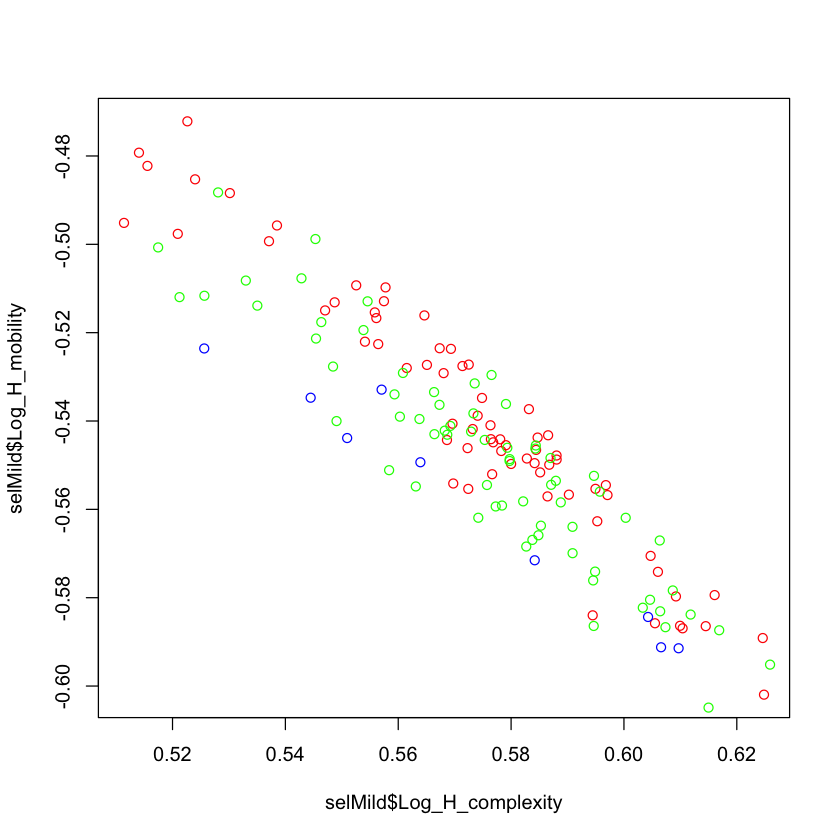

In [48]:
selMild = nDF[nDF$label == 'mild',]
plot(selMild$Log_H_complexity, selMild$Log_H_mobility, col='red')
selSevere = nDF[nDF$label == 'severe',]
points(selSevere$Log_H_complexity, selSevere$Log_H_mobility, col='blue')
selModerate = nDF[nDF$label == 'moderate',]

points(selModerate$Log_H_complexity, selModerate$Log_H_mobility, col='green')

In [44]:
# Check resulting predictions Linear
predictedSVM_linear <- predict(svmFit_linear, nDF_sel)
check <- rep(0, nrow(nDF_sel))

for(i in 1:nrow(nDF_sel)){
    if(c(nDF_sel$label[i])-c(predictedSVM_linear[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF_sel$label == 'mild'])/length(check[nDF_sel$label == 'mild'])
fracMild  
# fracModerate = sum(nDF_sel$check[nDF_sel$label == 'moderate'])/length(nDF_sel$check[nDF_sel$label == 'moderate'])
# fracModerate
fracSevere = sum(check[nDF_sel$label == 'severe'])/length(check[nDF_sel$label == 'severe'])
fracSevere

[1] 1

[1] 0

In [45]:
# Check resulting predictions Polynomial
predictedSVM_poly <- predict(svmFit_poly, nDF_sel)
check <- rep(0, nrow(nDF_sel))

for(i in 1:nrow(nDF_sel)){
    if(c(nDF_sel$label[i])-c(predictedSVM_poly[i]) == 0) check[i] <- 1
}

fracMild = sum(check[nDF_sel$label == 'mild'])/length(check[nDF_sel$label == 'mild'])
fracMild  
# fracModerate = sum(nDF_sel$check[nDF_sel$label == 'moderate'])/length(nDF_sel$check[nDF_sel$label == 'moderate'])
# fracModerate
fracSevere = sum(check[nDF_sel$label == 'severe'])/length(check[nDF_sel$label == 'severe'])
fracSevere

[1] 1

[1] 0.6

In [39]:
predict(svmFit_poly, nDF_sel)

[1] mild   mild   mild   mild   mild   mild   mild   mild   mild   mild  
[11] mild   mild   mild   mild   mild   mild   mild   mild   mild   mild  
[21] mild   severe mild   mild   mild   mild   mild   mild   mild   mild  
[31] severe mild   mild   mild   mild   mild   mild   mild   mild   mild  
[41] mild   mild   mild   mild   mild   mild   mild   mild   mild   mild  
[51] mild   severe mild   mild   mild   mild   severe mild   mild   mild  
[61] mild   mild   mild   mild   severe mild   mild   mild   mild   mild  
[71] mild   mild   mild   mild   mild   mild   mild   severe mild  
Levels: mild severe